In [1]:
from train import main
from utils.data_utils import get_loader

from urllib.request import urlretrieve
import os
from models.modeling import VisionTransformer, CONFIGS
import numpy as np
from torchvision import transforms
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import torch

In [2]:
os.makedirs("attention_data", exist_ok=True)
if not os.path.isfile("attention_data/ilsvrc2012_wordnet_lemmas.txt"):
    urlretrieve("https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt", "attention_data/ilsvrc2012_wordnet_lemmas.txt")
if not os.path.isfile("attention_data/ViT-B_16-224.npz"):
    urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz", "attention_data/ViT-B_16-224.npz")

imagenet_labels = dict(enumerate(open('attention_data/ilsvrc2012_wordnet_lemmas.txt')))

In [3]:
# Test Image

# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=1000, zero_head=False, img_size=224, vis=True)
model.load_from(np.load("attention_data/ViT-B_16-224.npz"))
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


In [4]:
im = Image.open("/home/haotian/Workspace/attention_gradient/images/12.jpg") #################
x = transform(im)
x.size()

torch.Size([3, 224, 224])

In [5]:

logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
    
# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")


# f = lambda x:torch.nn.Softmax(dim=-1)(model(x.unsqueeze(0))[0])[0,263] ###############
# g = torch.autograd.functional.jacobian(f, x)
# g = g.detach().numpy()[0]
# g = np.abs(g)
# g = cv2.resize(g, im.size)[..., np.newaxis]

tensor([849, 512, 473, 828, 618])
Prediction Label and Attention Map!

0.64680 : teapot
0.08163 : corkscrew, bottle_screw
0.03794 : can_opener, tin_opener
0.02409 : strainer
0.01916 : ladle


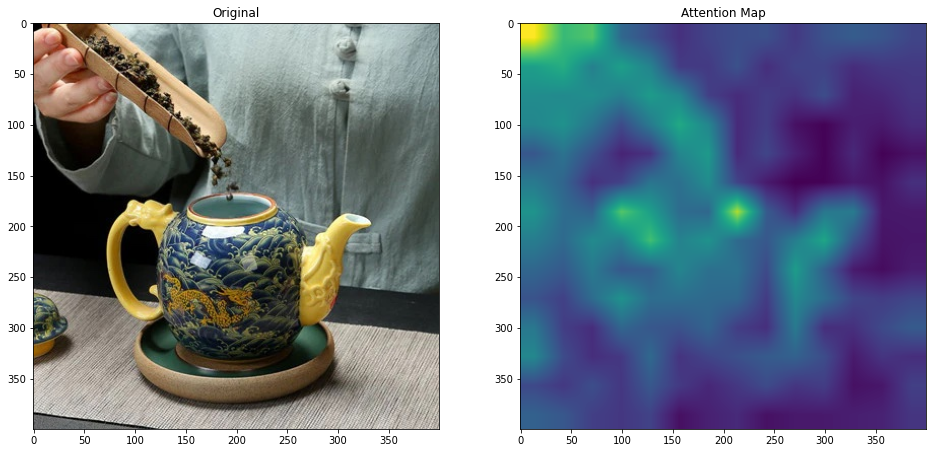

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(mask)
probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print(top5[0,:5])
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

idx = top5[0,0].item()

In [8]:
cgrid = np.linspace(0, 1, 50)
print(idx)
res = []
f = lambda x:torch.nn.Softmax(dim=-1)(model(x.unsqueeze(0))[0])[0,idx] ###############

for c in cgrid:
    s = c*x
    g = torch.autograd.functional.jacobian(f, s)
    g = g.detach().numpy()
    # g = np.abs(g)
    res.append(g[np.newaxis,:])

res = np.concatenate(res)
igradient = np.trapz(res, x=cgrid, axis=0)

849


In [9]:
res = torch.tensor(igradient)
res = torch.sum(res,axis=0)
res = res.cpu().numpy()
res =  cv2.resize(res, im.size)

res = np.abs(res[...,None])*np.array(im)
# res = np.abs(res)
res = ((res - res.min())/(res.max()-res.min()))



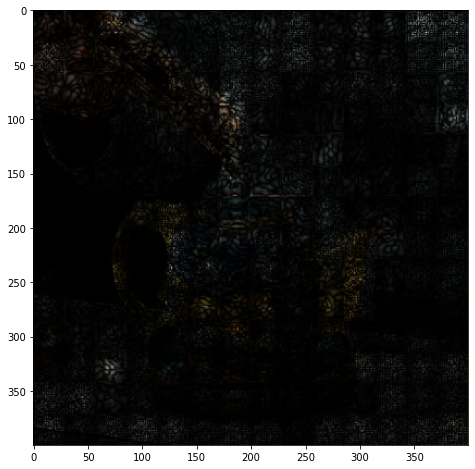

In [10]:
fig, ax1= plt.subplots(ncols=1, figsize=(8, 8))

ax1.imshow(res)

In [11]:
def plotg(filename):
    
    im = Image.open(filename) #################
    x = transform(im)
    x.size()

    logits, att_mat = model(x.unsqueeze(0))

    att_mat = torch.stack(att_mat).squeeze(1)

    # Average the attention weights across all heads.
    att_mat = torch.mean(att_mat, dim=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_att = torch.eye(att_mat.size(1))
    aug_att_mat = att_mat + residual_att
    aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

    # Recursively multiply the weight matrices
    joint_attentions = torch.zeros(aug_att_mat.size())
    joint_attentions[0] = aug_att_mat[0]

    for n in range(1, aug_att_mat.size(0)):
        joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])
        
    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_att_mat.size(-1)))
    mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask * im).astype("uint8")


    # f = lambda x:torch.nn.Softmax(dim=-1)(model(x.unsqueeze(0))[0])[0,263] ###############
    # g = torch.autograd.functional.jacobian(f, x)
    # g = g.detach().numpy()[0]
    # g = np.abs(g)
    # g = cv2.resize(g, im.size)[..., np.newaxis]
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

    ax1.set_title('Original')
    ax2.set_title('Attention Map')
    _ = ax1.imshow(im)
    _ = ax2.imshow(mask)
    probs = torch.nn.Softmax(dim=-1)(logits)
    top5 = torch.argsort(probs, dim=-1, descending=True)
    for idx in top5[0, :5]:
        print(f'{probs[0, idx.item()]:.5f} : {imagenet_labels[idx.item()]}', end='')

    idx = top5[0,0].item()
    cgrid = np.linspace(0, 1, 50)
    res = []
    f = lambda x:torch.nn.Softmax(dim=-1)(model(x.unsqueeze(0))[0])[0,idx] ###############

    for c in cgrid:
        s = c*x
        g = torch.autograd.functional.jacobian(f, s)
        g = g.detach().numpy()
        # g = np.abs(g)
        res.append(g[np.newaxis,:])

    res = np.concatenate(res)
    igradient = np.trapz(res, x=cgrid, axis=0)
    res = torch.tensor(igradient)
    res = torch.sum(res,axis=0)
    res = res.cpu().numpy()
    res =  cv2.resize(res, im.size)

    res = np.abs(res[...,None])*np.array(im)
    # res = np.abs(res)
    res = ((res - res.min())/(res.max()-res.min()))


    fig, ax1= plt.subplots(ncols=1, figsize=(8, 8))

    ax1.imshow(res)

0.99940 : daisy
0.00001 : vase
0.00000 : pot, flowerpot
0.00000 : ear, spike, capitulum
0.00000 : pinwheel


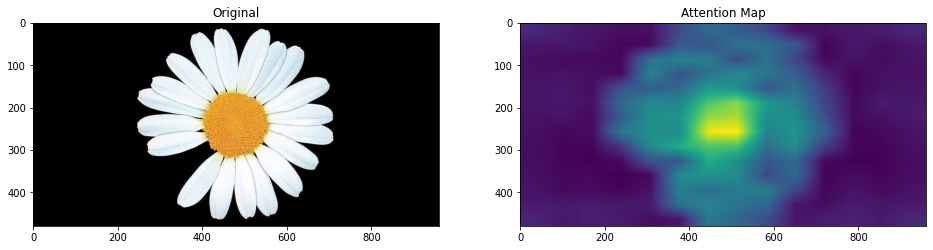

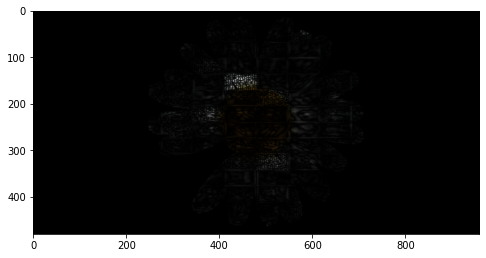

In [15]:
plotg('/home/haotian/Workspace/attention_gradient/images/.jpg')